<a href="https://colab.research.google.com/github/MKolaksazov/Machine-Learning/blob/master/hands-on%20ML%20textbook%20exercises/California%20housing%20price%20prediction/California_housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of housing prices (**California**)

###Using the native dataset from Colab

This prediction machine learning model is required to supply feeding information for the next ML model part of a pipeline in development.

We can use ***supervised*** learning, because we have labeled training data. It is a ***regression*** task, because we will be using it to predict a single parameter, as opposed to classification task, where we would require to fit the predicted outputs into different classes (e.g. cheap, medium, expensive), so we have more than one type of output and it is qualitative, not quantative. Moreover, it will be a ***multiple*** regression task, because we will be using multiple variables for the prediction (as an imput information). Also, it will be ***univariative*** in contrast to multivariative, because we will predict only a single price for the district, and not many. Finally, the data is comparatively small and will not change rapidly so it wil be a ***plain batch*** learning model.

The performance will be measured by the means of the RMSE (or the root mean square error) measurement, which is a measurement of the errors, the model makes.

$$\displaystyle{\displaylines{RMSE (X,h) = \sqrt[]{\frac{1}{m}\sum_{i = 1}^{m}(hx^{i}-y^{i})^{2}}}}$$

m - number of instances (districts)

xi - vector of parameters (input variables without label)

yi - the label (output parameter)

h -  hypothesis (prediction function)

$$hx^{i}=\hat{y}^{i}$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl

If we don't have the latter libraries present, we could install them, using the python command pip.

An isolated (virtual) environment (virtualenv, venv) could be a very usefull tool in order to handle different versions of the libraries, in other word to avoid conflict between verions of libraries.

In [3]:
df = pd.read_csv('sample_data/california_housing_train.csv')

Load the data from CSV file, and take a quick look-up at the data by the means of the head() method

In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


hist() method is used to draw a histogram for each of the numerical values from the dataframe

```%matplotlib inline``` uses jupyther's backend 

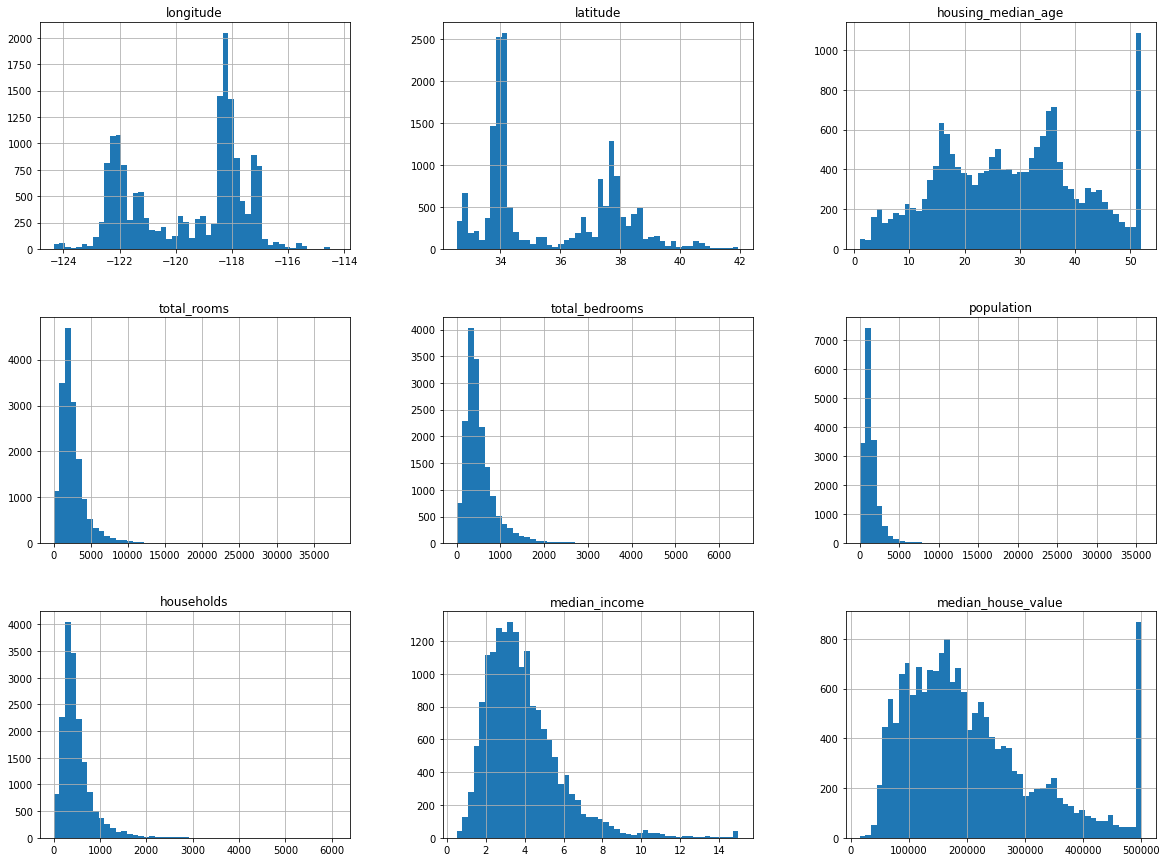

In [ ]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

In this case, the median_income variable is pre-processed. Actually, it starts from 5,000.0 \$ and ends at 150,000.0 \$, but for better convenience it was scaled between 0.5 and 15.0.

Furthermore, the median_house_value parameter is capped (which means that it does not allow bigger numbers than 500 000 \$). This will affect negatively the predictions later. To carry out this problem, we may need either to find data, labeled with prices further than the maximal, or to remove these capped (maxed) values from the dataframe.

And, finally, it could be seen, that many of these histograms have 'tails' or long side of the graph extending far out of the median (in our case to the right). This will cause some difficulties for the ML algorithm to perform very well, so we could 'improve' the shape of the histogram to a more bell-like one.

In [4]:
test_df = pd.read_csv('sample_data/california_housing_test.csv')

Splitting the dataframe to train and test data with a ratio of 20% test (and a seeded random generator).

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=1)

We have to ensure, that the test set will be up to scale with the true data from the dataframe, and won't be skewed when the data is randomized. This could be achieved by the means of scaling of the data into small set of subcategories, known as stratified sampling. 


In [6]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In our case, we will split the income set into 5 categories

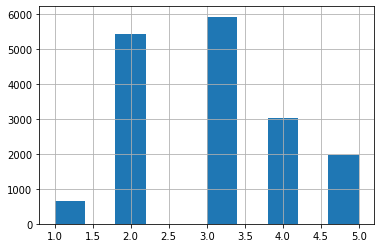

In [ ]:
df["income_cat"].hist()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

#scaling the train/test data to fit the representative sample from the dataset
#using the stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in split.split(df, df["income_cat"]):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [8]:
#showing that the ratio of the income after scaling is much more close to the 
#original data, in contrast to if it was only randomized
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.348235
2    0.318235
4    0.178235
5    0.116176
1    0.039118
Name: income_cat, dtype: float64

In [9]:
#remove the categories from the set
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [10]:
#copy of the set
copy_df = strat_train_set.copy()

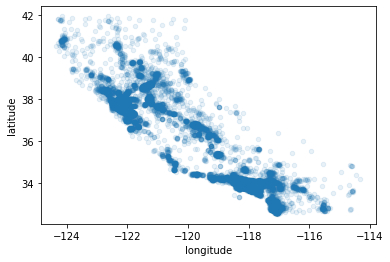

In [ ]:
#plot the geographical data (use alpha=0.1 to see more clearly the density)
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

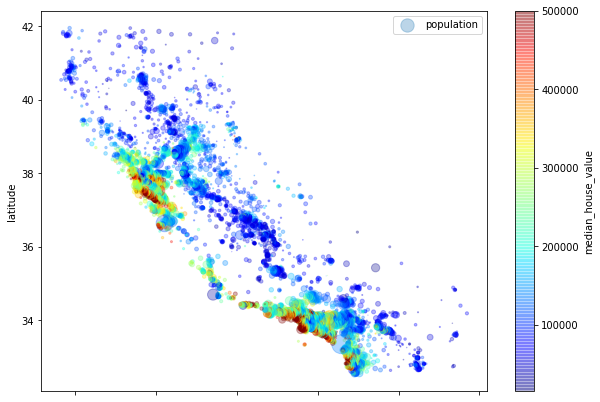

In [ ]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
s=df["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [11]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691871
total_rooms           0.130991
housing_median_age    0.106758
households            0.061031
total_bedrooms        0.045783
population           -0.027850
longitude            -0.044982
latitude             -0.144917
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a313519d0>,
      dtype=object)

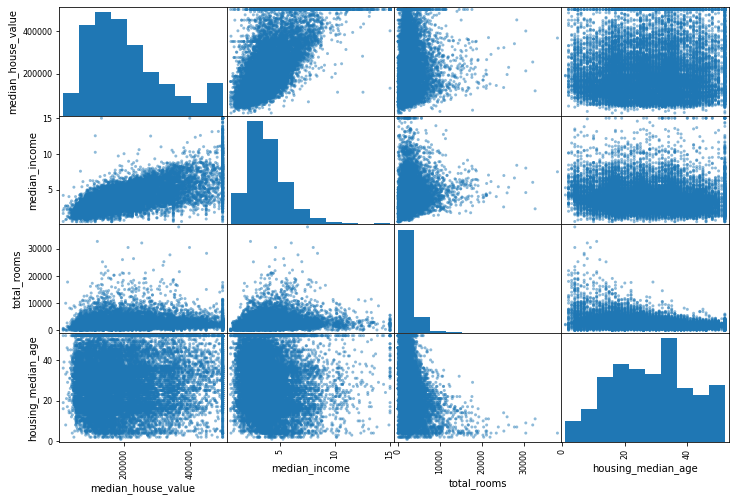

In [12]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))

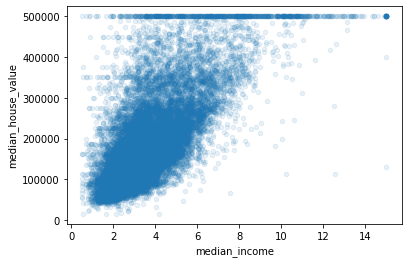

In [ ]:
df.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [13]:
from posixpath import defpath
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]= df["population"]/df["households"]

In [14]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691871
rooms_per_household         0.150081
total_rooms                 0.130991
housing_median_age          0.106758
households                  0.061031
total_bedrooms              0.045783
population                 -0.027850
population_per_household   -0.042764
longitude                  -0.044982
latitude                   -0.144917
bedrooms_per_room          -0.258190
Name: median_house_value, dtype: float64

In [15]:
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

In [16]:
df.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
6257,-118.25,34.12,11.0,1281.0,418.0,1584.0,330.0,2.8889
13165,-121.89,37.31,52.0,1994.0,404.0,1014.0,389.0,4.3882
2456,-117.60,33.72,36.0,1317.0,228.0,531.0,214.0,5.6346
15349,-122.29,37.89,52.0,2269.0,380.0,1004.0,371.0,5.1696
13736,-122.00,37.34,27.0,1716.0,290.0,817.0,301.0,5.9158
...,...,...,...,...,...,...,...,...
2973,-117.78,33.88,16.0,1800.0,238.0,871.0,234.0,6.6678
9384,-119.20,34.19,19.0,9503.0,1769.0,6370.0,1718.0,5.0016
2653,-117.67,33.66,4.0,10175.0,2181.0,4762.0,1929.0,4.7341
1818,-117.27,34.24,34.0,3687.0,756.0,941.0,367.0,2.8750


In [17]:
df.dropna(subset=["population"])
df.dropna(subset=["households"])
df.dropna(subset=["total_rooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
6257,-118.25,34.12,11.0,1281.0,418.0,1584.0,330.0,2.8889
13165,-121.89,37.31,52.0,1994.0,404.0,1014.0,389.0,4.3882
2456,-117.60,33.72,36.0,1317.0,228.0,531.0,214.0,5.6346
15349,-122.29,37.89,52.0,2269.0,380.0,1004.0,371.0,5.1696
13736,-122.00,37.34,27.0,1716.0,290.0,817.0,301.0,5.9158
...,...,...,...,...,...,...,...,...
2973,-117.78,33.88,16.0,1800.0,238.0,871.0,234.0,6.6678
9384,-119.20,34.19,19.0,9503.0,1769.0,6370.0,1718.0,5.0016
2653,-117.67,33.66,4.0,10175.0,2181.0,4762.0,1929.0,4.7341
1818,-117.27,34.24,34.0,3687.0,756.0,941.0,367.0,2.8750


Below is a small custom transformer class, that will be used to add a hyperparameter. It can be made to satisfy the requirements of sklearn framework principles.

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,
bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
df_extra_attribs = attr_adder.transform(df.values)

In [19]:
df_extra_attribs

array([[-118.25      ,   34.12      ,   11.        , ...,    2.8889    ,
           3.88181818,    4.8       ],
       [-121.89      ,   37.31      ,   52.        , ...,    4.3882    ,
           5.12596401,    2.6066838 ],
       [-117.6       ,   33.72      ,   36.        , ...,    5.6346    ,
           6.15420561,    2.48130841],
       ...,
       [-117.67      ,   33.66      ,    4.        , ...,    4.7341    ,
           5.27475376,    2.4686366 ],
       [-117.27      ,   34.24      ,   34.        , ...,    2.875     ,
          10.04632153,    2.5640327 ],
       [-118.37      ,   34.03      ,   37.        , ...,    3.0694    ,
           4.23287671,    3.30821918]])

Next, we can perform standartization or min-max scaling (normalization), where the very different parameters are scaled so that they fit in the range from 0 to 1.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
#housing_num_tr = num_pipeline.fit_transform(housing_num)
df_prepared = num_pipeline.fit_transform(df)

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

df_num = df#.drop("ocean_proximity", axis=1)
imputer.fit(df_num)
imputer.statistics_
df_num.median().values
#X = imputer.transform(df_num)
#df_tr = pd.DataFrame(X, columns=df_num.columns)

num_attribs = list(df_num)

In [22]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
#("cat", OneHotEncoder(), cat_attribs),
])
df_prepared = full_pipeline.fit_transform(df)

traning and evaluation

In [23]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

LinearRegression()

In [24]:
some_data = df.iloc[:5]
some_labels = df_labels.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [154950.11767589 280655.06143156 274886.97419169 297335.40410556
 308131.97947655]
Labels: [153100.0, 223600.0, 272500.0, 261400.0, 343100.0]


In [25]:
from sklearn.metrics import mean_squared_error
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df_labels, df_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68402.76248850006

In [26]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor()

In [27]:
df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [28]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, df_prepared, df_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [29]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71167.0286929  75495.08325372 75339.49887234 73942.54989841
 75387.41585515 68246.10322778 73020.83164018 72200.99866947
 75476.41956394 73019.12140415]
Mean: 73329.50510780471
Standard deviation: 2234.5533990964213


In [30]:
lin_scores = cross_val_score(lin_reg, df_prepared, df_labels,
 scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 67293.52589639  73109.62915079  68532.08367042  70919.20071557
  71007.52044004  66294.08954218  67030.14427217  66165.2785749
 111158.75355669  69063.69021548]
Mean: 73057.39160346228
Standard deviation: 12882.980017175743


In [31]:
from sklearn.ensemble import RandomForestRegressor
#fitting the new model
forest_reg = RandomForestRegressor()
forest_reg.fit(df_prepared, df_labels)

df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df_labels, df_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

#evaluating the scores
scores = cross_val_score(forest_reg, df_prepared, df_labels,
  scoring="neg_mean_squared_error", cv=10)
forest_rmse_1 = np.sqrt(-scores)
forest_rmse_1
#display function
display_scores(forest_rmse)
display_scores(forest_rmse_1)

Scores: 19111.434813224907
Mean: 19111.434813224907
Standard deviation: 0.0
Scores: [49953.33327104 50986.52360433 50837.62538668 55424.11616588
 53081.84107347 48778.64443402 51665.5124687  49133.4834549
 50371.31361986 53513.77748183]
Mean: 51374.61709607093
Standard deviation: 1979.9262609973555


In [32]:
#saving the model for later use

import joblib
joblib.dump(forest_reg, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

Fine-tuning the hyperparameters, by the means of grid, showing different combinations

In [33]:
# here, we have fine-tuning of the all 90 combinations, which is quite a lot
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(df_prepared, df_labels)
grid_search.best_params_
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30)

In [34]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

65279.06711761377 {'max_features': 2, 'n_estimators': 3}
56672.47724067487 {'max_features': 2, 'n_estimators': 10}
53885.965193473494 {'max_features': 2, 'n_estimators': 30}
61791.153057319454 {'max_features': 4, 'n_estimators': 3}
53099.14689395527 {'max_features': 4, 'n_estimators': 10}
51861.236700513415 {'max_features': 4, 'n_estimators': 30}
61364.52278493869 {'max_features': 6, 'n_estimators': 3}
54626.36828441961 {'max_features': 6, 'n_estimators': 10}
52126.818966445615 {'max_features': 6, 'n_estimators': 30}
61481.019938453624 {'max_features': 8, 'n_estimators': 3}
54827.688614598475 {'max_features': 8, 'n_estimators': 10}
52197.95158202367 {'max_features': 8, 'n_estimators': 30}
64364.85655029681 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55658.94253432189 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61304.218203554534 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53503.39312081297 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [35]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.09973756, 0.10288348, 0.04880532, 0.0187915 , 0.01945425,
       0.02052035, 0.01926487, 0.39667146, 0.06687771, 0.11885634,
       0.08813716])

In [36]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = full_pipeline.named_transformers_["cat"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs #+ cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.39667146168142775, 'median_income'),
 (0.1188563396173913, 'pop_per_hhold'),
 (0.10288348362083437, 'latitude'),
 (0.09973756013707764, 'longitude'),
 (0.08813716353455753, 'bedrooms_per_room'),
 (0.06687770859866629, 'rooms_per_hhold'),
 (0.04880531643805821, 'housing_median_age'),
 (0.020520348191596097, 'population'),
 (0.01945424598220467, 'total_bedrooms'),
 (0.01926486744850794, 'households'),
 (0.018791504749678185, 'total_rooms')]

In [37]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2

In [ ]:
final_rmse

52518.32682059427

In [38]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
 loc=squared_errors.mean(),
 scale=stats.sem(squared_errors)))

array([50124.08920599, 54703.73328647])

#Exercises
Using this chapter’s housing dataset:
1. Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyper‐
parameters such as kernel="linear" (with various values for the C hyperpara‐
meter) or kernel="rbf" (with various values for the C and gamma
hyperparameters). Don’t worry about what these hyperparameters mean for now.
How does the best SVR predictor perform?
2. Try replacing GridSearchCV with RandomizedSearchCV.
3. Try adding a transformer in the preparation pipeline to select only the most
important attributes.
4. Try creating a single pipeline that does the full data preparation plus the final
prediction.
5. Automatically explore some preparation options using GridSearchCV.

1) Task #1

In [40]:
from sklearn.svm import SVR
svr_reg = SVR(kernel = 'rbf')
svr_reg.fit(df_prepared, df_labels)

#evaluating the scores
scores = cross_val_score(svr_reg, df_prepared, df_labels,
  scoring="neg_mean_squared_error", cv=10)
svr_rmse = np.sqrt(-scores)
svr_rmse

#display function
display_scores(svr_rmse)

Scores: [117287.39801803 119299.17438324 114694.06667368 121441.79888308
 125205.31390566 121424.49089848 115579.2197301  121390.87979376
 115188.29383304 116673.73377388]
Mean: 118818.43698929487
Standard deviation: 3300.591496590048


In [47]:
# here, we have fine-tuning of the all 90 combinations, which is quite a lot
from sklearn.model_selection import GridSearchCV
param_grid = [
{"alpha": [1e0, 0.1, 1e-2, 1e-3]},
{'bootstrap': [False], "alpha": [1e0, 0.1, 1e-2, 1e-3]},
]
svr_reg = SVR(kernel = 'linear')
grid_search = GridSearchCV(svr_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(df_prepared, df_labels)
grid_search.best_params_
grid_search.best_estimator_

ValueError: ignored

In [43]:
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__cache_size', 'estimator__coef0', 'estimator__degree', 'estimator__epsilon', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)